In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torch.optim.lr_scheduler import StepLR

c:\ProgramData\anaconda3\Lib\site-packages\torch\cuda\__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
# loading the chestmnist dataset
data_path = ""
data = np.load(f"{data_path}chestmnist.npz")

train_images = data['train_images']
train_labels = data['train_labels']

validation_images = data['val_images']
validation_labels = data['val_labels']

test_images = data['test_images']
test_labels = data['test_labels']


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Calculate pos_weight for imbalanced classes
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float)
pos_counts = train_labels_tensor.sum(dim=0)
neg_counts = len(train_labels_tensor) - pos_counts
pos_weight = (neg_counts / pos_counts).to(device)

In [5]:
print(data)

NpzFile 'chestmnist.npz' with keys: train_images, val_images, test_images, train_labels, val_labels...


In [6]:
print(train_images[0].shape)

(28, 28)


In [7]:
print(type(train_images))

<class 'numpy.ndarray'>


In [8]:
print(f"The shape of train images: {train_images.shape}, train labels: {train_labels.shape}")
print(f"The shape of validation images: {validation_images.shape}, validation labels: {validation_labels.shape}")
print(f"The shape of test images: {test_images.shape}, test labels: {test_labels.shape}")


The shape of train images: (78468, 28, 28), train labels: (78468, 14)
The shape of validation images: (11219, 28, 28), validation labels: (11219, 14)
The shape of test images: (22433, 28, 28), test labels: (22433, 14)


In [9]:
class ChestMNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self): 
        return len(self.images) # number of samples
    
    def __getitem__(self, idx):
        img = self.images[idx]

        if self.transform: # apply transformations
            img = self.transform(img)

        label = self.labels[idx]
        label = torch.tensor(label, dtype=torch.float)
        
        return img, label

In [10]:
from torchvision import transforms # to apply transformations to the images

transforms_with_augmentation = transforms.Compose([
    transforms.ToTensor(), # convert to tensor
    transforms.RandomRotation(degrees=10), # Randomly rotates the image between -10 and +10 degrees
    transforms.Normalize((0.5,), (0.5,)) # normalize the images
])

transforms = transforms.Compose([
    transforms.ToTensor(), # convert to tensor
    transforms.Normalize((0.5,), (0.5,)) # normalize the images
])

In [11]:
train_dataset = ChestMNISTDataset(train_images, train_labels, transform=transforms_with_augmentation)
validation_dataset = ChestMNISTDataset(validation_images, validation_labels, transform=transforms)
test_dataset = ChestMNISTDataset(test_images, test_labels, transform=transforms)

In [21]:
# creating the dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=1000, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [13]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1) # not pretrained
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False) # Change input channels from 3 to 1 (grayscale images)
model.fc = nn.Linear(512, 14)  # final fully connected layer

model = model.to(device) # move the model to the GPU

In [14]:
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0006)
scheduler = StepLR(optimizer, step_size=5, gamma=0.8)

In [15]:
import time
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_auc_score, f1_score

train_f1s = []
val_f1s = []

train_losses = []
train_aucs = []
train_accs = []
val_losses = []
val_aucs = []
val_accs = []
train_epoch_times = []

import time
from sklearn.metrics import roc_auc_score

epoch = 1

In [23]:
val_f1_micros = []

In [30]:
def train_model(number_of_epochs):
    global epoch
    
    for i in range(number_of_epochs):
        model.train()
        total_loss = 0
        all_outputs = []
        all_targets = []
        
        start_time = time.time()

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss_value = criterion(outputs, targets)  # Use criterion
            loss_value.backward()
            optimizer.step()

            total_loss += loss_value.item()
            all_outputs.append(torch.sigmoid(outputs).detach().cpu())
            all_targets.append(targets.cpu())

        all_outputs = torch.cat(all_outputs).numpy()
        all_targets = torch.cat(all_targets).numpy()
        
        avg_loss = total_loss / len(train_loader)
        auc = roc_auc_score(all_targets, all_outputs, average='macro')
        train_acc = ((all_outputs > 0.5) == all_targets).mean()
        train_f1 = f1_score(all_targets, (all_outputs > 0.5), average='macro')  # ADD THIS

        
        train_losses.append(avg_loss)
        train_aucs.append(auc)
        train_accs.append(train_acc)
        train_f1s.append(train_f1)  # ADD THIS

        
        epoch_time = time.time() - start_time
        train_epoch_times.append(epoch_time)
        
        scheduler.step()  # Step scheduler after training
        
        # Validation
        model.eval()
        val_total_loss = 0
        val_outputs = []
        val_targets = []

        with torch.no_grad():
            for inputs, targets in validation_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_loss_value = criterion(outputs, targets)  # Use criterion
                val_total_loss += val_loss_value.item()
                val_outputs.append(torch.sigmoid(outputs).cpu())
                val_targets.append(targets.cpu())
        
        val_outputs = torch.cat(val_outputs).numpy()
        val_targets = torch.cat(val_targets).numpy()
        
        val_avg_loss = val_total_loss / len(validation_loader)
        val_auc = roc_auc_score(val_targets, val_outputs, average='macro')
        val_acc = ((val_outputs > 0.5) == val_targets).mean()
        val_f1 = f1_score(val_targets, (val_outputs > 0.5), average='macro')  
        val_f1_micro = f1_score(val_targets, (val_outputs > 0.5), average='micro')  


        
        val_losses.append(val_avg_loss)
        val_aucs.append(val_auc)
        val_accs.append(val_acc)
        val_f1s.append(val_f1)
        val_f1_micros.append(val_f1_micro)

        if (epoch) >= 3:
            torch.save(model.state_dict(), f"models/model_epoch_{epoch}.pt")

        print(f"Epoch [{epoch}], Train Loss: {avg_loss:.4f}, Train AUC: {auc:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}, Val Loss: {val_avg_loss:.4f}, Val AUC: {val_auc:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}, Val F1 Micro: {val_f1_micro:.4f}, Time: {epoch_time:.2f}s, LR: {optimizer.param_groups[0]['lr']:.6f}")

        epoch += 1

In [17]:
training_epochs = 20
train_model(training_epochs)

Epoch [1], Train Loss: 1.3484, Train AUC: 0.5860, Train Acc: 0.5533, Train F1: 0.1124, Val Loss: 1.3226, Val AUC: 0.5736, Val Acc: 0.5581, Val F1: 0.0924, Time: 62.28s, LR: 0.000600
Epoch [2], Train Loss: 1.3099, Train AUC: 0.6159, Train Acc: 0.5626, Train F1: 0.1197, Val Loss: 1.9024, Val AUC: 0.6343, Val Acc: 0.5566, Val F1: 0.1144, Time: 63.47s, LR: 0.000600
Epoch [3], Train Loss: 1.3016, Train AUC: 0.6215, Train Acc: 0.5699, Train F1: 0.1214, Val Loss: 1.5743, Val AUC: 0.6475, Val Acc: 0.6660, Val F1: 0.1250, Time: 62.69s, LR: 0.000600
Epoch [4], Train Loss: 1.2896, Train AUC: 0.6242, Train Acc: 0.5608, Train F1: 0.1212, Val Loss: 1.5218, Val AUC: 0.6385, Val Acc: 0.5747, Val F1: 0.1185, Time: 63.39s, LR: 0.000600
Epoch [5], Train Loss: 1.2816, Train AUC: 0.6300, Train Acc: 0.5672, Train F1: 0.1227, Val Loss: 1.3994, Val AUC: 0.6306, Val Acc: 0.4903, Val F1: 0.1147, Time: 59.72s, LR: 0.000480
Epoch [6], Train Loss: 1.2475, Train AUC: 0.6506, Train Acc: 0.5760, Train F1: 0.1269, Val

In [27]:
training_epochs = 10
train_model(training_epochs)

Epoch [22], Train Loss: 1.0972, Train AUC: 0.7437, Train Acc: 0.6618, Train F1: 0.1535, Val Loss: 1.2010, Val AUC: 0.7295, Val Acc: 0.6616, Val F1: 0.1483, Val F1 Micro: 0.1663, Time: 46.81s, LR: 0.000246
Epoch [23], Train Loss: 1.0969, Train AUC: 0.7444, Train Acc: 0.6641, Train F1: 0.1542, Val Loss: 1.2059, Val AUC: 0.7295, Val Acc: 0.6589, Val F1: 0.1483, Val F1 Micro: 0.1599, Time: 47.22s, LR: 0.000246
Epoch [24], Train Loss: 1.0939, Train AUC: 0.7461, Train Acc: 0.6618, Train F1: 0.1542, Val Loss: 1.2232, Val AUC: 0.7263, Val Acc: 0.6802, Val F1: 0.1514, Val F1 Micro: 0.1661, Time: 46.46s, LR: 0.000246
Epoch [25], Train Loss: 1.0869, Train AUC: 0.7495, Train Acc: 0.6646, Train F1: 0.1554, Val Loss: 1.2193, Val AUC: 0.7340, Val Acc: 0.6731, Val F1: 0.1529, Val F1 Micro: 0.1691, Time: 46.44s, LR: 0.000197
Epoch [26], Train Loss: 1.0783, Train AUC: 0.7528, Train Acc: 0.6686, Train F1: 0.1561, Val Loss: 1.2548, Val AUC: 0.7314, Val Acc: 0.6474, Val F1: 0.1476, Val F1 Micro: 0.1643, Ti

In [31]:
# reseting the optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
scheduler = StepLR(optimizer, step_size=3, gamma=0.8)

In [32]:
training_epochs = 10
train_model(training_epochs)

Epoch [32], Train Loss: 1.1090, Train AUC: 0.7451, Train Acc: 0.6670, Train F1: 0.1549, Val Loss: 1.3539, Val AUC: 0.7136, Val Acc: 0.6920, Val F1: 0.1517, Val F1 Micro: 0.1670, Time: 50.14s, LR: 0.000500
Epoch [33], Train Loss: 1.1044, Train AUC: 0.7417, Train Acc: 0.6563, Train F1: 0.1525, Val Loss: 1.3217, Val AUC: 0.7281, Val Acc: 0.7011, Val F1: 0.1538, Val F1 Micro: 0.1708, Time: 49.03s, LR: 0.000500
Epoch [34], Train Loss: 1.0862, Train AUC: 0.7511, Train Acc: 0.6696, Train F1: 0.1569, Val Loss: 1.4169, Val AUC: 0.7230, Val Acc: 0.6705, Val F1: 0.1503, Val F1 Micro: 0.1727, Time: 49.66s, LR: 0.000400
Epoch [35], Train Loss: 1.0769, Train AUC: 0.7539, Train Acc: 0.6703, Train F1: 0.1568, Val Loss: 1.2584, Val AUC: 0.7322, Val Acc: 0.6847, Val F1: 0.1540, Val F1 Micro: 0.1741, Time: 48.95s, LR: 0.000400
Epoch [36], Train Loss: 1.0716, Train AUC: 0.7564, Train Acc: 0.6740, Train F1: 0.1580, Val Loss: 1.2851, Val AUC: 0.7302, Val Acc: 0.6863, Val F1: 0.1541, Val F1 Micro: 0.1727, Ti

In [ ]:
training_epochs = 10
train_model(training_epochs)

In [18]:
print(f"training_epochs: {training_epochs}")
print(f"train_losses length: {len(train_losses)}")
print(f"train_aucs length: {len(train_aucs)}")
print(f"train_accs length: {len(train_accs)}")
print(f"val_losses length: {len(val_losses)}")
print(f"val_aucs length: {len(val_aucs)}")
print(f"val_accs length: {len(val_accs)}")
print(f"train_epoch_times length: {len(train_epoch_times)}")

training_epochs: 20
train_losses length: 20
train_aucs length: 20
train_accs length: 20
val_losses length: 20
val_aucs length: 20
val_accs length: 20
train_epoch_times length: 20


In [19]:
train_accs = train_accs[:-1]  # Adjusting the length to match other metrics

In [20]:
import pandas as pd

# Create DataFrame with all metrics
metrics_df = pd.DataFrame({
    'epoch': range(1, training_epochs + 1),
    'train_loss': train_losses,
    'train_auc': train_aucs,
    'train_acc': train_accs,  # Adjusted to match lengths
    'val_loss': val_losses,
    'val_auc': val_aucs,
    'val_acc': val_accs,
    'epoch_time': train_epoch_times
})

# Save to CSV
metrics_df.to_csv('training_metrics.csv', index=False)

ValueError: All arrays must be of the same length

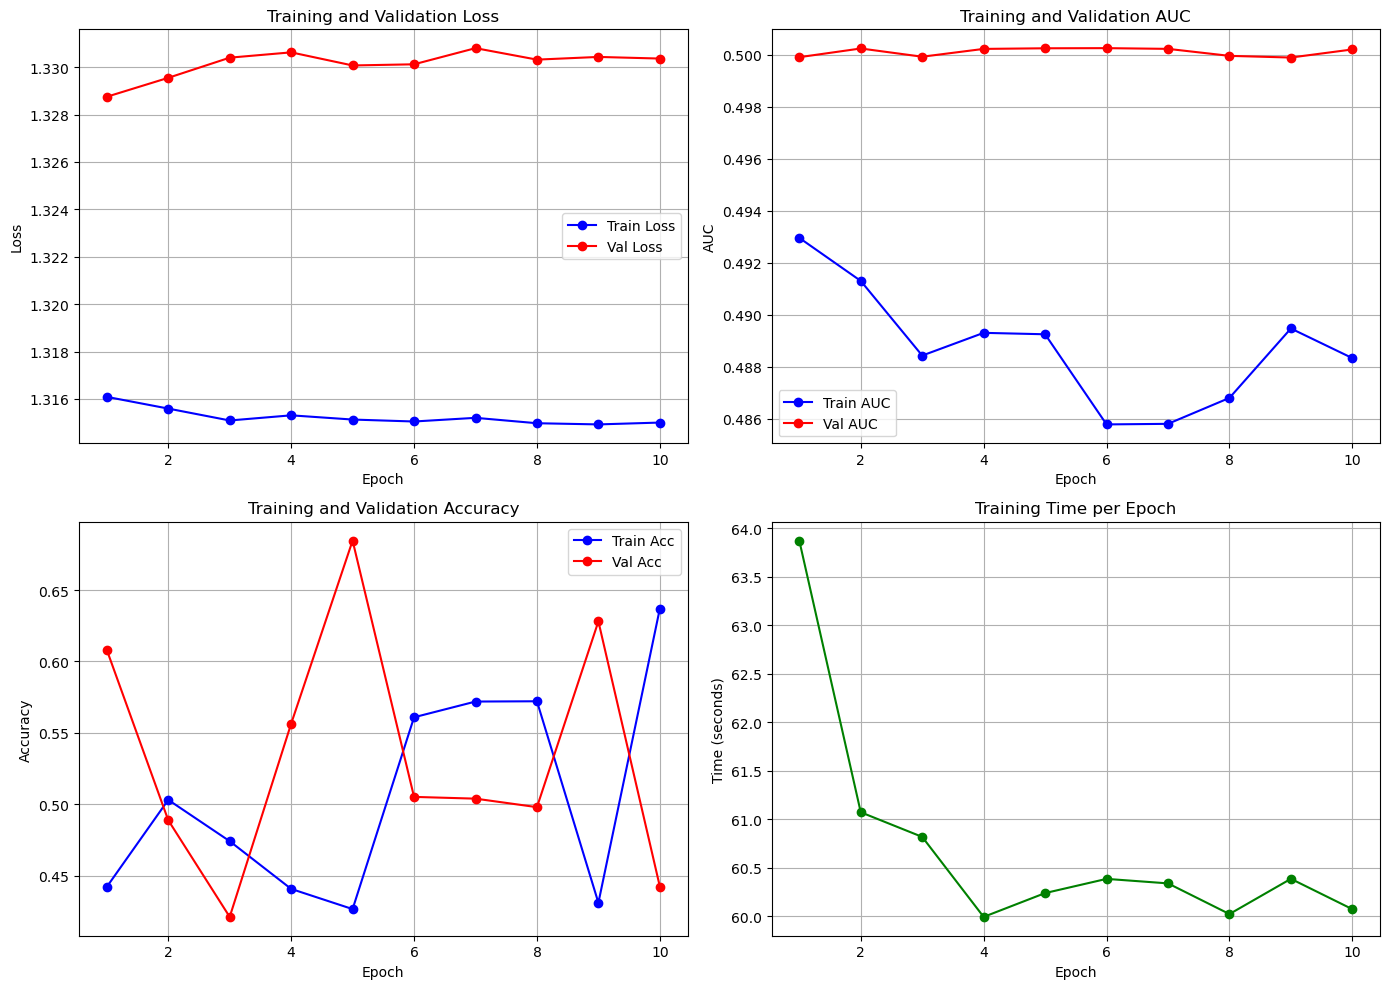

In [ ]:
import matplotlib.pyplot as plt
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

epochs = range(1, len(train_losses) + 1)

# Plot 1: Loss
axes[0, 0].plot(epochs, train_losses, 'b-o', label='Train Loss')
axes[0, 0].plot(epochs, val_losses, 'r-o', label='Val Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot 2: AUC
axes[0, 1].plot(epochs, train_aucs, 'b-o', label='Train AUC')
axes[0, 1].plot(epochs, val_aucs, 'r-o', label='Val AUC')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('AUC')
axes[0, 1].set_title('Training and Validation AUC')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot 3: Accuracy
axes[1, 0].plot(epochs, train_accs, 'b-o', label='Train Acc')
axes[1, 0].plot(epochs, val_accs, 'r-o', label='Val Acc')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_title('Training and Validation Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot 4: Epoch Time
axes[1, 1].plot(epochs, train_epoch_times, 'g-o')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Time (seconds)')
axes[1, 1].set_title('Training Time per Epoch')
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig('training_plots.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# The best model is at epoch 6

In [ ]:
# calculate test accuracy

model.eval() # set the model to evaluation mode
with torch.no_grad():
    all_predictions = []
    all_labels = []
    
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        predictions = torch.sigmoid(outputs) > 0.5
        
        all_predictions.append(predictions.cpu())
        all_labels.append(targets.cpu())
    
    all_predictions = torch.cat(all_predictions)
    all_labels = torch.cat(all_labels)
    
    test_accuracy = (all_predictions == all_labels).float().mean().item()
    print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9476


In [ ]:
# All the code below is for evaluating and loading the best model (epoch 6)

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models




In [ ]:
# loading the chestmnist dataset
data_path = "data"
data = np.load(f"{data_path}/chestmnist_224.npz")

train_images = data['train_images']
train_labels = data['train_labels']

validation_images = data['val_images']
validation_labels = data['val_labels']

test_images = data['test_images']
test_labels = data['test_labels']


In [ ]:
class ChestMNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self): 
        return len(self.images) # number of samples
    
    def __getitem__(self, idx):
        img = self.images[idx]

        if self.transform: # apply transformations
            img = self.transform(img)

        label = self.labels[idx]
        label = torch.tensor(label, dtype=torch.float)
        
        return img, label

In [ ]:
from torchvision import transforms # to apply transformations to the images

transforms_with_augmentation = transforms.Compose([
    transforms.ToTensor(), # convert to tensor
    transforms.RandomRotation(degrees=10), # Randomly rotates the image between -10 and +10 degrees
    transforms.Normalize((0.5,), (0.5,)) # normalize the images
])

transforms = transforms.Compose([
    transforms.ToTensor(), # convert to tensor
    transforms.Normalize((0.5,), (0.5,)) # normalize the images
])

In [ ]:
test_dataset = ChestMNISTDataset(test_images, test_labels, transform=transforms)

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
model = models.resnet18(weights=None) # not pretrained
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False) # Change input channels from 3 to 1 (grayscale images)
model.fc = nn.Linear(512, 14)  # final fully connected layer

model.load_state_dict(torch.load('models/model_epoch_6.pt'))

model = model.to(device) # move the model to the GPU

C:\Users\mamou\AppData\Local\Temp\ipykernel_31188\116624970.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/model_epoch_6.pt'))


In [ ]:
# calculate test accuracy

model.eval() # set the model to evaluation mode
with torch.no_grad():
    all_predictions = []
    all_labels = []
    
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        predictions = torch.sigmoid(outputs) > 0.5
        
        all_predictions.append(predictions.cpu())
        all_labels.append(targets.cpu())
    
    all_predictions = torch.cat(all_predictions)
    all_labels = torch.cat(all_labels)
    
    test_accuracy = (all_predictions == all_labels).float().mean().item()
    print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9478
